# Ecosystem respiration

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import date, timedelta
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
import PIL
import datetime
import seaborn as sns
from scipy import stats
from pylr2 import regress2
import random
from statistics import mode
from scipy import stats
import glob
#from datetime import datetime
import pytz
import os
import re

## Functions

In [122]:
# # Conversion Fm (Fraction Modern) to $\Delta$^14^C
def fm_D14C(fm,yr,lft=8267):
    dcy=fm*np.exp((1950-yr)/lft)
    D14C=(dcy-1)*1000
    return D14C

#Conversion $\Delta$^14^C to Fm (Fraction Modern)
def D14C_fm(D14C,yr,lft=8267):
    fm=(D14C/1000+1)*np.exp((yr-1950)/lft)
    return fm
# index o nearest date
def nearest_ind(items, pivot):
    time_diff = np.abs([date - pivot for date in items])
    return time_diff.argmin()+1
def create_percentage_vector(start_value, percentages):
    result = [start_value]
    for percentage in percentages:
        increment = start_value * (1+percentage)
        #current_value += increment
        result.append(increment)
    return result

## Read data

In [123]:
# d13C
fw=pd.read_excel('~/Documents/MSCA/DISEQ/Prades_model/Data/LabResults/Air_ecosystem_d13C.xls')
fw['sampling time']=pd.to_datetime(fw['sampling time'])
#fw['time']=pd.to_datetime(fw['sampling time'].astype(str) + " " + fw['sampling time'].astype(str))
H=fw['height'].unique()
dtime=np.zeros(len(fw)); day=np.zeros(len(fw))
for i in range(len(fw)):
    dtime[i]=fw['sampling time'][i].hour+fw['sampling time'][i].minute/60
    day[i]=fw['sampling time'][i].day
fw["dtime"]=dtime; fw["day"]=day
fw=fw.rename(columns={'sample description':'Probe'})

#d14C
fw2=pd.read_excel('~/Documents/MSCA/DISEQ/Prades_model/Data/LabResults/Air_ecosystem_d14C.xlsx',header=31)

# Merge
df=pd.merge(fw,fw2,on="Probe")

exp=['Drought','Control']

# CO2 profile
pth= '/home/_ehoyos/Documents/MSCA/DISEQ/Prades_model/Data/CO2profileData/'
files=glob.glob(os.path.join(pth,"*.dat"))
files.sort()
files=files[44:] #  # These are only the files produced after May 30
all_df=[];all_df2=[] 
for f in files:
    dfw=pd.read_csv(f,header=1)
    df=dfw[['TIMESTAMP','CO2Lvl1_Avg','CO2Lvl2_Avg','CO2Lvl3_Avg','CO2Lvl4_Avg','CO2Lvl5_Avg','CO2Lvl6_Avg','CO2Lvl7_Avg']]
    df2=dfw[['TIMESTAMP','CO2Lvl1_Std','CO2Lvl2_Std','CO2Lvl3_Std','CO2Lvl4_Std','CO2Lvl5_Std','CO2Lvl6_Std','CO2Lvl7_Std']]
    df=df.drop([0,1]); df2=df2.drop([0,1])# remove second and third title lines.
    all_df.append(df); all_df2.append(df2) 
    
dCO2=pd.concat(all_df, ignore_index=True); eCO2=pd.concat(all_df2, ignore_index=True)
dCO2['TIMESTAMP']=pd.to_datetime(dCO2['TIMESTAMP']); eCO2['TIMESTAMP']=pd.to_datetime(eCO2['TIMESTAMP'])
dCO2['dates_utc']=dCO2['TIMESTAMP'].dt.tz_localize('UTC'); eCO2['dates_utc']=eCO2['TIMESTAMP'].dt.tz_localize('UTC')
dCO2['dates_cest']=dCO2['dates_utc'].dt.tz_convert('Europe/Berlin'); eCO2['dates_cest']=eCO2['dates_utc'].dt.tz_convert('Europe/Berlin')
dCO2=dCO2.drop([0,1]); eCO2=eCO2.drop([0,1]) # remove two points from another day.
dCO2[dCO2.columns[1:8]]=dCO2[dCO2.columns[1:8]].astype(float); eCO2[eCO2.columns[1:8]]=eCO2[eCO2.columns[1:8]].astype(float)
dCO2=dCO2.reset_index(drop=True); eCO2=eCO2.reset_index(drop=True) 

In [124]:
F14C_atmod=0.9975615225273415 # Modeled value.

bkg=pd.read_excel('Data/LabResults/Air_ecosystem_d14C.xlsx',header=31) # Measured in the field.
bkg=bkg[bkg['Plot']=='bkg']

F14C_atm=np.mean([bkg.F14C.mean()]) # mean
D14C_atm=fm_D14C(F14C_atm,2024)

### CO$_2$ profile

For soil CO$_2$, it was selected the mean of the night from 2-3 of May.



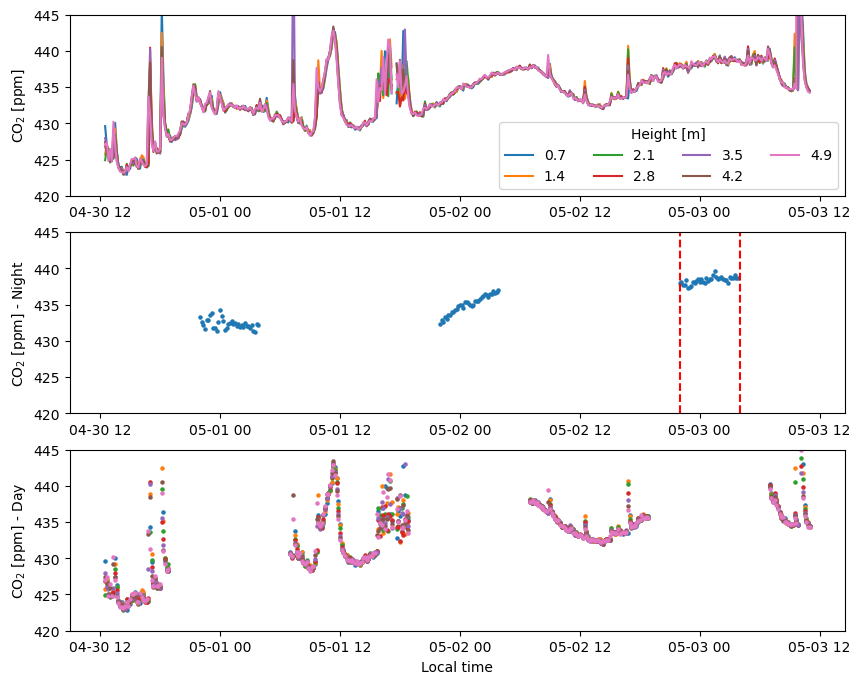

In [125]:
height=np.round(np.arange(0.7,5,0.7),1)
palette=sns.color_palette("tab10",7)
fig,ax=plt.subplots(3,figsize=(10,8))
for i in range(len(height)):ax[0].plot(dCO2['dates_cest'],dCO2[dCO2.columns[1+i]],label=height[i],color=palette[i])

ax[0].set_ylim(420,445)
ax[0].legend(title='Height [m]',ncol=4)

ax[0].set_ylabel('CO$_2$ [ppm]')
xlimg=ax[0].get_xlim()

# Night
dCO2['hour']=dCO2['dates_cest'].dt.hour
dCO2night=dCO2[(dCO2['hour']>=22)|(dCO2['hour']<4)]
ax[1].scatter(dCO2night['dates_cest'],dCO2night[dCO2.columns[1]],marker='o',s=5)
ax[1].set_ylim(420,445)
ax[1].set_xlim(xlimg)
ax[1].set_ylabel('CO$_2$ [ppm] - Night')
ax[1].axvline(datetime.datetime(2024,5,2,20),color='red', linestyle='--')
ax[1].axvline(datetime.datetime(2024,5,3,2),color='red', linestyle='--')

# Day
dCO2day=dCO2[(dCO2['hour']>=7)&(dCO2['hour']<=18)]
for i in range(len(height)):ax[2].scatter(dCO2day['dates_cest'],dCO2day[dCO2day.columns[1+i]],color=palette[i],s=5)
ax[2].set_ylim(420,445)
ax[2].set_xlim(xlimg)
ax[2].set_ylabel('CO$_2$ [ppm] - Day')
ax[2].set_xlabel('Local time')

CO2soil=dCO2night[dCO2night['TIMESTAMP']>='2024-05-02 22:00:00'].CO2Lvl1_Avg.mean()


### CO2 and climate variables

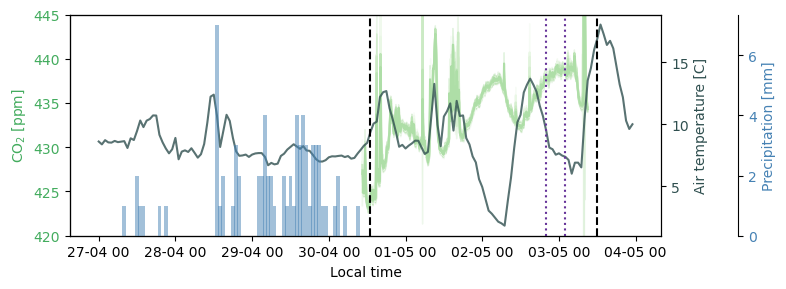

In [126]:
# CO2
height=np.round(np.arange(0.7,5,0.7),1)
palette=sns.color_palette("Greens",20)
#cmap = plt.get_cmap('cividis')
fig,ax=plt.subplots(1,figsize=(8,3))
for i in range(len(height)):
    ax.plot(dCO2['dates_cest'],dCO2[dCO2.columns[1+i]],label=height[i],color=palette[i])
    ax.fill_between(dCO2['dates_cest'],dCO2[dCO2.columns[1+i]]-eCO2[eCO2.columns[1+i]],
                    dCO2[dCO2.columns[1+i]]+eCO2[eCO2.columns[1+i]],alpha=0.3,color=palette[i])

ax.set_ylim(420,445)
#ax.legend(title='Height [m]',ncol=4)

ax.set_ylabel('CO$_2$ [ppm]',color=palette[12])
ax.set_xlabel('Local time')
ax.tick_params(axis='y', labelcolor=palette[12])

# Temperature
fw2=pd.read_csv('~/Documents/MSCA/DISEQ/Prades_model/Data/Climate/Prades_hourly.csv')

fw2['datetime']=pd.to_datetime(fw2['datetime'],format='%Y-%m-%d %H:%M:%S')
df=fw2.set_index('datetime')
df=df.loc['2024-04-27':'2024-05-03']
ax2=ax.twinx()
ax2.plot(df.index,df['Ta'],color='darkslategray',alpha=0.8)
ax2.set_ylabel('Air temperature [C]', color='darkslategray')
ax2.tick_params(axis='y', labelcolor='darkslategray')


# Precipitation
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.13))

ax3.bar(df.index,df.P, width=0.05, color='steelblue', alpha=0.5)
ax3.set_ylabel('Precipitation [mm]', color='steelblue')
ax3.tick_params(axis='y', labelcolor='steelblue')

ax3.axvline(x=datetime.datetime(2024,4,30,12,57,0), color='black', linestyle='--')
ax3.axvline(x=datetime.datetime(2024,5,3,11,47,0), color='black', linestyle='--')

ax3.axvline(datetime.datetime(2024,5,2,20),color='rebeccapurple',linestyle=':')
ax3.axvline(datetime.datetime(2024,5,3,2),color='rebeccapurple',linestyle=':')

import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H'))
fig.tight_layout() 
fig.savefig('Figures/Data_field/CO2_Ta_P.pdf')

### F$^{14}$C soil respiration - FFSR



In [127]:
control=[5,7,9,10]
drought=[2,3,4,6]

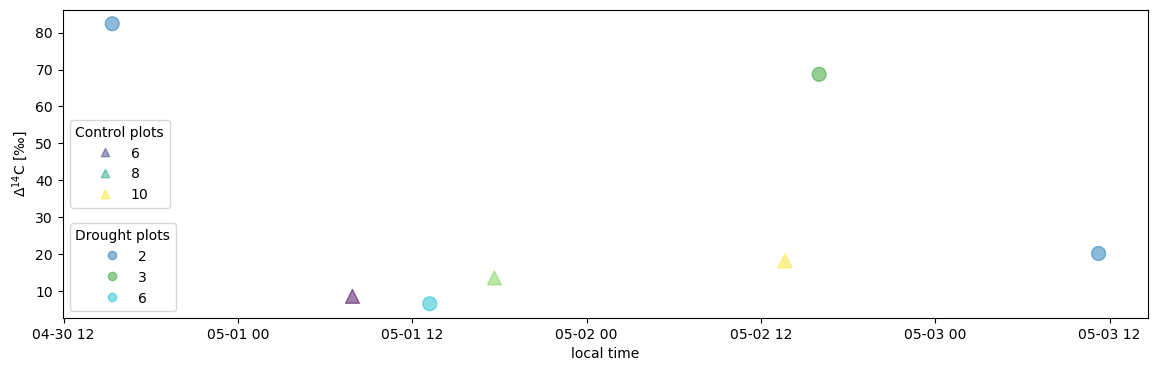

In [128]:
data=pd.read_excel('Data/LabResults/Air_soil_field_d14C.xlsx',header=30)
data['datetime'] = pd.to_datetime(data['Collection_date'].dt.strftime('%Y-%m-%d') + data['Collection_time'].astype(str), format = '%Y-%m-%d%H:%M:%S')
plot=np.empty(len(data),dtype=int); treatment=['']*len(data)
for i in range(len(data)):
    plot[i]=data['Probe'][i].split('_')[3]
    treatment[i]=data['Probe'][i].split('_')[4]
data['plot']=plot; data['treatment']=treatment

data.loc[data['treatment']=='control','treatment']='Control'
data.loc[data['treatment']=='drought','treatment']='Drought'

con=data[data['plot'].isin(control)] ; conf=con
dro=data[data['plot'].isin(drought)] ; drof=dro

b=data[data.columns[4]]-D14C_atm # substract D14C atmospheric
data['D']=b

dataf=data

v='D'# F: F14C, D: D14C.

if v=='F': vv=data.columns[2];tity='F$^{14}$C [-]'  
if v=='D': vv=data.columns[4];tity='$\Delta^{14}$C [‰]'
    
fig=plt.subplots(figsize=[14,4])
con=con[con[con.columns[4]]>-300] # removes very low values.
scatter1=plt.scatter(con.datetime,con[vv],c=con['plot'],marker='^',alpha=0.5,s=100)
legend1=plt.legend(*scatter1.legend_elements(num=3),title="Control plots",loc="center left")
plt.gca().add_artist(legend1)
dro=dro[dro[dro.columns[4]]>-300] # removes very low values.
scatter2=plt.scatter(dro.datetime,dro[vv],c=dro['plot'],cmap=plt.cm.tab10,marker='o',alpha=0.5,s=100)
plt.ylabel(tity); plt.xlabel('local time')
legend2=plt.legend(*scatter2.legend_elements(),title='Drought plots',loc="lower left")

FFSRconF14C=con.F14C.mean(); FFSRdroF14C=dro.F14C.mean()
FFSRconD14C=con[con.columns[4]].mean(); FFSRdroD14C=dro[dro.columns[4]].mean()

### F$^{14}$C soil respiration - Incubations

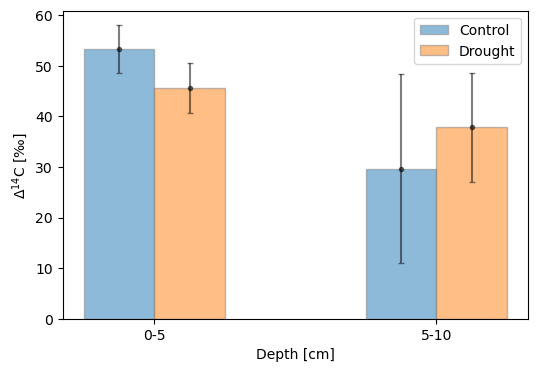

In [129]:
data=pd.read_excel('Data/LabResults/Air_soil_incub_d14C.xlsx',header=30)

temp=re.compile("([a-zA-Z]+)([0-9]+)")
plot=np.empty(len(data),dtype=int); depth=['']*len(data); treat=['']*len(data)
for i in range(len(data)):
    b=data['Probe'][i].split('_')[1]
    plot[i]=temp.match(b).groups()[1]
    depth[i]=(data['Probe'][i].split('_')[-1]).split(' ')[0]
    if plot[i] in control: treat[i]='Control'
    if plot[i] in drought: treat[i]='Drought'
    
data['plot']=plot; data['depth']=depth; data['treatment']=treat 
depths=data.depth.unique()

con=data[data['plot'].isin(control)] 
dro=data[data['plot'].isin(drought)] 

b=data[data.columns[4]]-D14C_atm # substract D14C atmospheric
data['D']=b
datai=data

v='D'# F: F14C, D: D14C.

if v=='F': vv=data.columns[2];tity='F$^{14}$C [-]'  
if v=='D': vv=data.columns[4];tity='$\Delta^{14}$C [‰]'
   
fig=plt.subplots(figsize=(6,4)) 
cmap=plt.cm.tab10
colors=cmap(np.linspace(0,1,8))
barWidth=0.25 
br1=np.arange(2) 
br2=[x+barWidth for x in br1]

res=np.empty(len(depths));std=np.empty(len(depths))
for i in range(len(depths)):
    res[i]=con[vv][con.depth==depths[i]].mean()
    a=con[vv][con.depth==depths[i]]
    std[i]=a.std()/np.sqrt(len(a[~a.isna()]))
plt.bar(br1,res,width=barWidth,edgecolor='grey',label ='Control',alpha=0.5) 
plt.errorbar(br1,res,std,fmt='.',color='Black',alpha=0.5,capsize=2)

res=np.empty(len(depths));std=np.empty(len(depths))
for i in range(len(depths)):
    res[i]=dro[vv][dro.depth==depths[i]].mean()
    a=dro[vv][dro.depth==depths[i]]
    std[i]=a.std()/np.sqrt(len(a[~a.isna()]))
plt.bar(br2,res,width=barWidth,edgecolor='grey',label='Drought',alpha=0.5) 
plt.errorbar(br2,res,std,fmt='.',color='Black',alpha=0.5,capsize=2)

plt.legend()
plt.ylabel(tity);plt.xlabel('Depth [cm]')
plt.xticks([r+barWidth/2 for r in range(len(depths))],depths)

INCconF14C=con.F14C.mean(); INCdroF14C=dro.F14C.mean()
INCconD14C=con[con.columns[4]].mean(); INCdroD14C=dro[dro.columns[4]].mean()

### Observed F$^{14}$C and CO$_2$

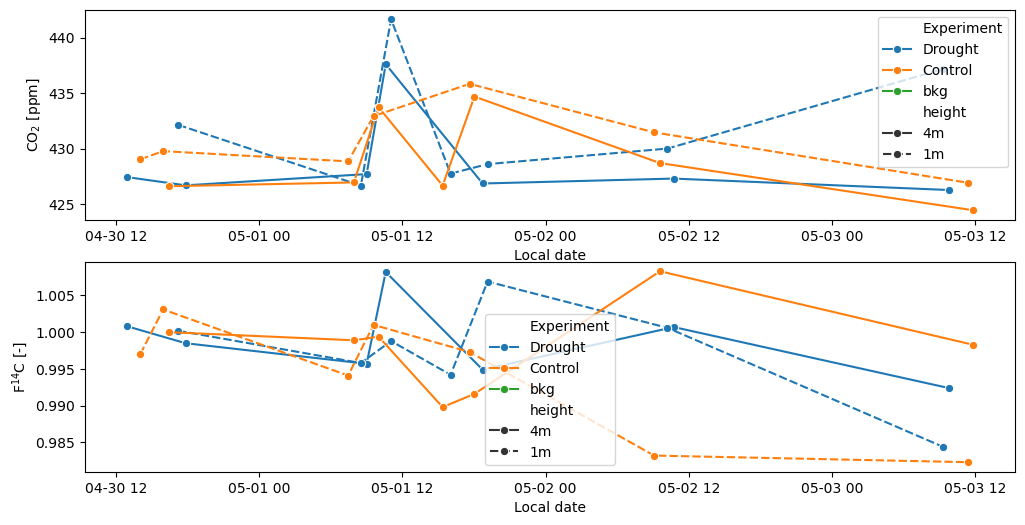

In [130]:
# d13C
fw=pd.read_excel('~/Documents/MSCA/DISEQ/Prades_model/Data/LabResults/Air_ecosystem_d13C.xls')
fw['sampling time']=pd.to_datetime(fw['sampling time'])
#fw['time']=pd.to_datetime(fw['sampling time'].astype(str) + " " + fw['sampling time'].astype(str))
H=fw['height'].unique()
dtime=np.zeros(len(fw)); day=np.zeros(len(fw))
for i in range(len(fw)):
    dtime[i]=fw['sampling time'][i].hour+fw['sampling time'][i].minute/60
    day[i]=fw['sampling time'][i].day
fw["dtime"]=dtime; fw["day"]=day
fw=fw.rename(columns={'sample description':'Probe'})

#d14C
fw2=pd.read_excel('~/Documents/MSCA/DISEQ/Prades_model/Data/LabResults/Air_ecosystem_d14C.xlsx',header=31)

# Merge
df=pd.merge(fw,fw2,on="Probe")

fig,ax=plt.subplots(2,figsize=(12,6))
palette=sns.color_palette("tab10",3)

# by height.
sns.lineplot(data=df,x="sampling time",y="CO2",hue="Experiment",style='height',marker="o",palette=palette,ax=ax[0])
ax[0].set_xlabel('Local date')
ax[0].set_ylabel(r'CO$_{2}$ [ppm]')

sns.lineplot(data=df,x="sampling time",y="F14C",hue="Experiment",style='height', marker="o",palette=palette,ax=ax[1])
ax[1].set_xlabel('Local date')
ax[1].set_ylabel(r'F$^{14}$C [-]')

OBScon=df[df.Treatment=='Control'].reset_index(drop=True) 
OBSdro=df[df.Treatment=='Drought'].reset_index(drop=True) 
bkg=df[df.Experiment=='bkg'].reset_index(drop=True)

### Balances under different assumptions

In [131]:
percentages=np.round(np.arange(0.1,0.6,0.1),1)
pp=np.insert(percentages,[0],0)
palette=sns.color_palette("cividis",len(pp))
palette2=sns.color_palette("crest",len(pp))

bkgD14C=bkg[bkg.columns[21]][0]; bkgCO2=bkg.CO2[0] # only the first value
FFSRD14C=np.array([FFSRconD14C,FFSRdroD14C])
incD14C=np.array([INCconD14C,INCdroD14C])

fs=np.array([3.49,2.0]) # Soil flux. mumolCO2 m-2 s-1 (Asensio et al. 2007). Data from April, mean 2003 and 2004.
fp=np.array([8.25,8.75]) # Net photosynthetic rate. mumolCO2 m-2 s-1 (Asensio et al. 2007). Data from April, mean 2003 and 2004.
fvd=np.array([1.04,1.58]) # Leaf respiration during the day. mumolCO2 m-2 s-1 (Sperlich1 et al. 2016). Data from spring.
fvn=np.array([1.53,1.79]) # Leaf respiration during the night. mumolCO2 m-2 s-1 (Sperlich1 et al. 2016). Data from spring.

fERd=fs+fvd-fp
fERn=fs+fvn
treatn=['Control','Drought']
ytit=['$\Delta^{14}$C$_v$  [‰]','$\Delta^{14}$C$_{ER}$  [‰]']

##### considering photosynthesis (assumed CO2 ER: CO2 measurements during the day). 
This is the same than directly solving for DCO2ER

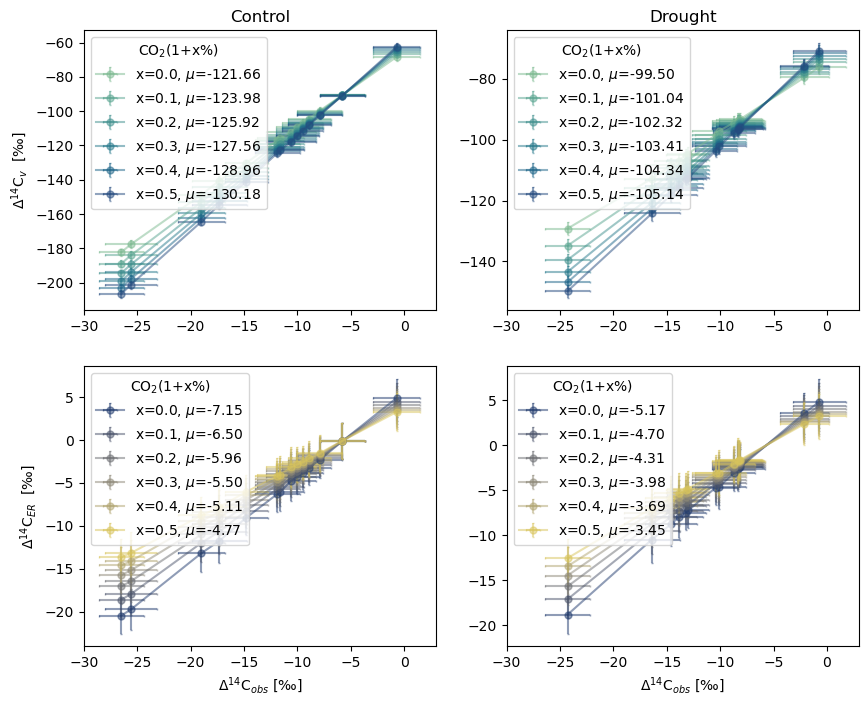

In [132]:
fig,ax=plt.subplots(2,2,figsize=(10,8))
for j in range(2): #treatments
    if j==0:obs=OBScon
    if j==1:obs=OBSdro
    vegD14C=np.zeros([len(obs),len(pp)])*np.nan; ERD14C=np.zeros([len(obs),len(pp)])*np.nan
    for i in range(len(obs)):
        obsD14C=obs[obs.columns[21]][i]; obsCO2=obs.CO2[i]; err=obs[obs.columns[22]]
        x=obs['sampling time'][i]
        CO2ER=dCO2.iloc[(dCO2['dates_cest']-x.tz_localize('Europe/Berlin')).abs().argsort()[0]][2:5].mean()
        CO2ERv=create_percentage_vector(CO2ER,percentages)
        for k in range(len(CO2ERv)):        
            vegD14C[i,k]=((obsD14C*obsCO2-bkgD14C*bkgCO2)*(fERd[j]/CO2ERv[k])-FFSRD14C[j]*fs[j]+obsD14C*fp[j])/fvd[j]
            ERD14C[i,k]=(FFSRD14C[j]*fs[j]+vegD14C[i,k]*fvd[j]-obsD14C*fp[j])/fERd[j]
            
    for f in range(len(CO2ERv)):
        indexed_pairs=list(enumerate(zip(obs[obs.columns[21]],ERD14C[:,f],err,vegD14C[:,f]))) # it sorted the values of both vectors.
        indexed_pairs.sort(key=lambda x: x[1][0])
        sorted_obs=[pair[1][0] for pair in indexed_pairs]
        sorted_er=[pair[1][1] for pair in indexed_pairs]
        sorted_erro=[pair[1][2] for pair in indexed_pairs]
        sorted_veg=[pair[1][3] for pair in indexed_pairs]
                
        ax[0,j].errorbar(sorted_obs,sorted_veg,yerr=sorted_erro,xerr=sorted_erro,fmt='-o',capsize=1,markersize=5,
                         alpha=0.5,color=palette2[f],label='x={0:.1f}'.format(pp[f])+', $\mu$={0:.2f}'.format(vegD14C[:,f].mean()))
        ax[1,j].errorbar(sorted_obs,sorted_er,yerr=sorted_erro,xerr=sorted_erro,fmt='-o',capsize=1,markersize=5,
                         alpha=0.5,color=palette[f],label='x={0:.1f}'.format(pp[f])+', $\mu$={0:.2f}'.format(ERD14C[:,f].mean()))
    
    ax[1,j].set_xlabel('$\Delta^{14}$C$_{obs}$ [‰]')
    ax[0,j].set_title(treatn[j])
    ax[0,j].legend(title=r'CO$_2$(1+x%)'); ax[1,j].legend(title=r'CO$_2$(1+x%)')
    ax[0,j].set_xlim(-30,3); ax[1,j].set_xlim(-30,3)
    if j==0:ERc=ERD14C
    if j==1:ERd=ERD14C

ax[0,0].set_ylabel(ytit[0]); ax[1,0].set_ylabel(ytit[1])
ERD14Ca1=[ERc,ERd]

##### without photosynthesis (assumed CO2 ER: CO2 measurements during the night)

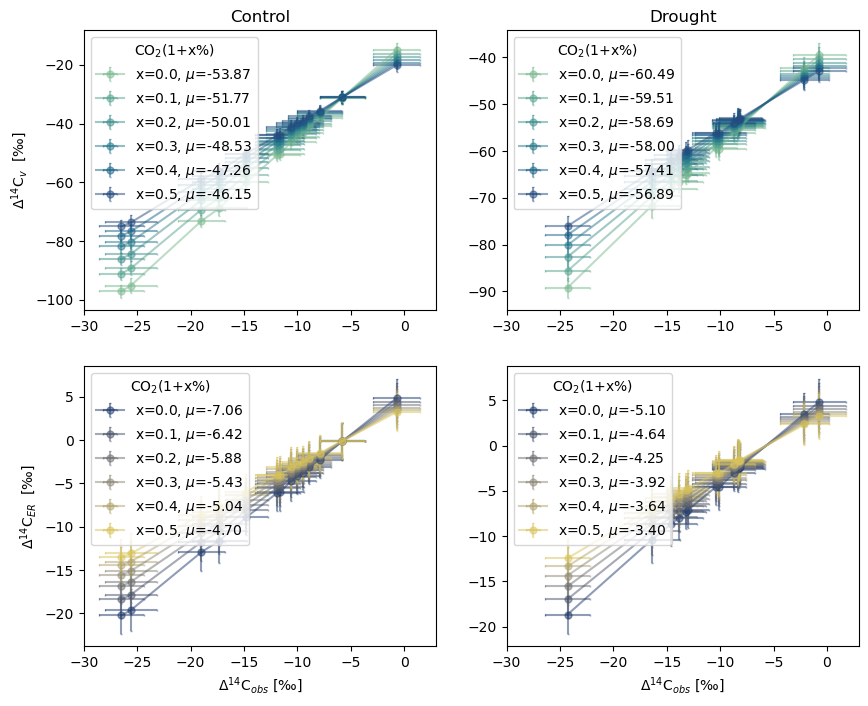

In [133]:
fig,ax=plt.subplots(2,2,figsize=(10,8))
for j in range(2): #treatments
    if j==0:obs=OBScon
    if j==1:obs=OBSdro
    vegD14C=np.zeros([len(obs),len(pp)])*np.nan; ERD14C=np.zeros([len(obs),len(pp)])*np.nan
#     vegD14C=np.zeros([len(obs),len(pp)])*np.nan; ERD14C=np.zeros([len(obs),len(pp)])*np.nan
    for i in range(len(obs)):
        obsD14C=obs[obs.columns[21]][i]; obsCO2=obs.CO2[i]; err=obs[obs.columns[22]]
        x=obs['sampling time'][i]
        CO2ER=dda()
        CO2ERv=create_percentage_vector(CO2ER,percentages)
        for k in range(len(CO2ERv)):        
            vegD14C[i,k]=((obsD14C*obsCO2-bkgD14C*bkgCO2)*(fERn[j]/CO2ERv[k])-FFSRD14C[j]*fs[j])/fvn[j]
            ERD14C[i,k]=(FFSRD14C[j]*fs[j]+vegD14C[i,k]*fvn[j])/fERn[j]
                    
    for f in range(len(CO2ERv)):
        indexed_pairs=list(enumerate(zip(obs[obs.columns[21]],ERD14C[:,f],err,vegD14C[:,f]))) # it sorted the values of both vectors.
        indexed_pairs.sort(key=lambda x: x[1][0])
        sorted_obs=[pair[1][0] for pair in indexed_pairs]
        sorted_er=[pair[1][1] for pair in indexed_pairs]
        sorted_erro=[pair[1][2] for pair in indexed_pairs]
        sorted_veg=[pair[1][3] for pair in indexed_pairs]
                
        ax[0,j].errorbar(sorted_obs,sorted_veg,yerr=sorted_erro,xerr=sorted_erro,fmt='-o',capsize=1,markersize=5,
                         alpha=0.5,color=palette2[f],label='x={0:.1f}'.format(pp[f])+', $\mu$={0:.2f}'.format(vegD14C[:,f].mean()))
        ax[1,j].errorbar(sorted_obs,sorted_er,yerr=sorted_erro,xerr=sorted_erro,fmt='-o',capsize=1,markersize=5,
                         alpha=0.5,color=palette[f],label='x={0:.1f}'.format(pp[f])+', $\mu$={0:.2f}'.format(ERD14C[:,f].mean()))
    
    ax[1,j].set_xlabel('$\Delta^{14}$C$_{obs}$ [‰]')
    ax[0,j].set_title(treatn[j])
    ax[0,j].legend(title=r'CO$_2$(1+x%)'); ax[1,j].legend(title=r'CO$_2$(1+x%)')
    ax[0,j].set_xlim(-30,3); ax[1,j].set_xlim(-30,3)
    if j==0:ERc=ERD14C
    if j==1:ERd=ERD14C

ax[0,0].set_ylabel(ytit[0]); ax[1,0].set_ylabel(ytit[1])
ERD14Ca2=[ERc,ERd]

##### solving direcly for $\Delta^{14}_{ER}$

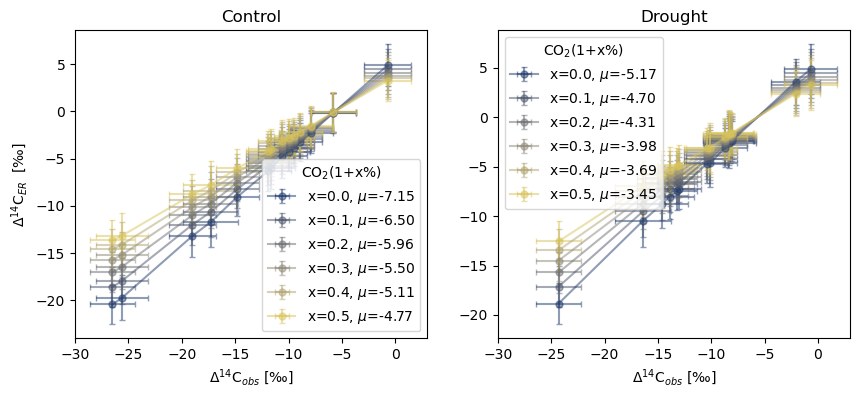

In [135]:
fig,ax=plt.subplots(1,2,figsize=(10,4))

for j in range(2): #treatments
    if j==0:obs=OBScon
    if j==1:obs=OBSdro
    vegD14C=np.zeros([len(obs),len(pp)])*np.nan; ERD14C=np.zeros([len(obs),len(pp)])*np.nan
    for i in range(len(obs)):
        obsD14C=obs[obs.columns[21]][i]; obsCO2=obs.CO2[i]; err=obs[obs.columns[22]]
        x=obs['sampling time'][i]
        CO2ER=dCO2.iloc[(dCO2['dates_cest']-x.tz_localize('Europe/Berlin')).abs().argsort()[0]][2:5].mean()
        CO2ERv=create_percentage_vector(CO2ER,percentages)
        for k in range(len(CO2ERv)):        
            ERD14C[i,k]=(obsD14C*obsCO2-bkgD14C*bkgCO2)/CO2ERv[k]

    for f in range(len(CO2ERv)):
        indexed_pairs=list(enumerate(zip(obs[obs.columns[21]],ERD14C[:,f],err))) # it sorted the values of both vectors.
        indexed_pairs.sort(key=lambda x: x[1][0])
        sorted_obs=[pair[1][0] for pair in indexed_pairs]
        sorted_er=[pair[1][1] for pair in indexed_pairs]
        sorted_erro=[pair[1][2] for pair in indexed_pairs]
        
        ax[j].errorbar(sorted_obs,sorted_er,yerr=sorted_erro,xerr=sorted_erro,fmt='-o',capsize=2,markersize=5,alpha=0.5,
                      label='x={0:.1f}'.format(pp[f])+', $\mu$={0:.2f}'.format(ERD14C[:,f].mean()),color=palette[f])

    ax[j].legend(title=r'CO$_2$(1+x%)')
    ax[j].set_xlabel('$\Delta^{14}$C$_{obs}$ [‰]')
    ax[j].set_title(treatn[j])
    ax[j].set_xlim(-30,3)
#     ERD14C=pd.DataFrame(ERD14C)
#     ERD14C.to_csv('Data/D14CER'+treat[k]+'.csv', index=False)  

    if j==0:ERc=ERD14C
    if j==1:ERd=ERD14C

ax[0].set_ylabel(ytit[1])
ERD14Ca3=[ERc,ERd]


# fig.savefig('Figures/Data_field/ER_balance_Prades.pdf')

### Miller-Tans plots of F$^{14}$C 

#### without background data (eq 5 in Miller & Tans 2003) 
It is the same than using a constant background (!).

In [257]:
df.columns[21]

'∆14C  (‰)'

Control
Drought


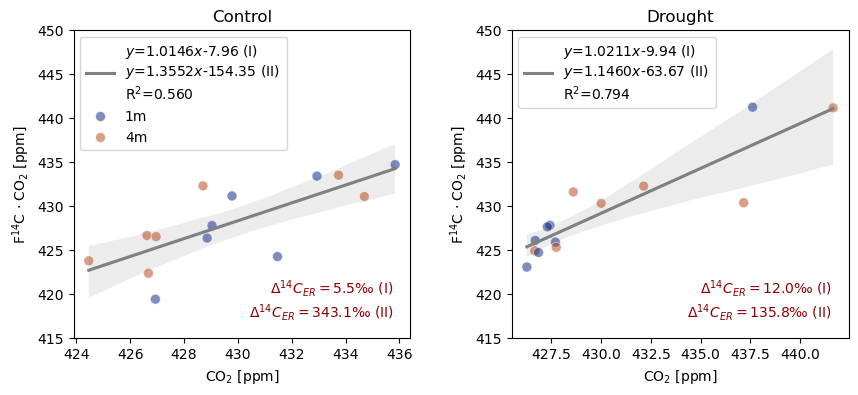

In [137]:
palette2=sns.color_palette("dark",2)
fig,ax=plt.subplots(1,2,figsize=(10,4))
from matplotlib.legend import Legend

s=50

exp=['Control','Drought']
D14I=np.zeros(2);D14II=np.zeros(2)
for i in range(2): #drought and control.
    #fw2=fw[fw['Experiment']==exp[i]]
    print(exp[i])
    fw2=df[df['Experiment']==exp[i]]
    MT_x=fw2["CO2"]
    MT_y=fw2.F14C*fw2.CO2
    slope,intercept,r_value,pv,se=stats.linregress(MT_x,MT_y) # Type I.
    results=regress2(MT_x,MT_y) # Type II.
    sns.regplot(data=fw2,x=MT_x,y=MT_y,ax=ax[i],scatter=False,color='gray',
            label="$y$={0:.4f}$x${1:.2f}".format(slope,intercept)+" (I)\n$y$={0:.4f}$x${1:.2f}".format(results['slope'],results['intercept'])+
            " (II) \nR$^2$={0:.3f}".format(results['r']**2))
    sns.scatterplot(data=fw2,x=MT_x,y=MT_y,hue="height",palette=palette2,s=s,
                alpha=0.5,ax=ax[i])
    handles,labels=ax[i].get_legend_handles_labels()
    if i==0:ax[i].legend(handles=handles[0:],labels=labels[0:],loc='upper left')
    else:ax[i].legend(handles=handles[0:],labels=labels[0:1],loc='upper left')
    ax[i].set_xlabel(r'CO$_2$ [ppm]')
    ax[i].set_ylabel(r'F$^{14}$C $\cdot$ CO$_2$ [ppm]')
    ax[i].set_ylim(415,450)
    ax[i].set_title(treatn[i])
    D14I[i]=slope
    D14II[i]=results['slope']


    ax[i].text(0.95,0.05, '$\Delta^{14}C_{ER}=$'+"{:.1f}".format(fm_D14C(D14I[i],2024))+
               '‰ (I)'+'\n$\Delta^{14}C_{ER}=$'+"{:.1f}".format(fm_D14C(D14II[i],2024))+'‰ (II)',
        verticalalignment='bottom', horizontalalignment='right',transform=ax[i].transAxes,
        color='darkred', fontsize=10)

 
plt.subplots_adjust(wspace=0.3,hspace=0.3)
fig.savefig('Figures/Data_field/KP_F14C_Prades_TypeI_TypeII.pdf')

### All results together




0
1


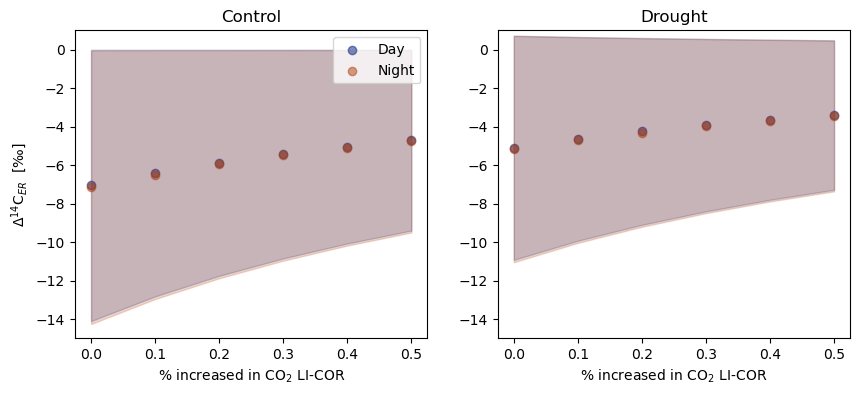

In [155]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
ll=['Day','Night']
exp=['Control','Drought']

for  j in range(2): # treatments
    for i in range(2):# approaches
        if i==0:ER=ERD14Ca2
        if i==1:ER=ERD14Ca3
        ers=pd.DataFrame(ER[j])
        er=ers.mean()
        ax[j].scatter(pp,er,alpha=0.5,label=ll[i],color=palette2[i])
        ax[j].set_ylim(-15,1)
#         ax[j].errorbar(pp,er,yerr=ers.std(),fmt='-o',capsize=2,markersize=5,alpha=0.5,
#                       label=ll[i],color=palette2[i])
        ax[j].fill_between(pp,er-ers.std(),er+ers.std(),alpha=0.2,color=palette2[i])
           
        if i==0:
            print(j)
            ERD14C=pd.DataFrame(er,columns=['D14C'])
            ERD14C.to_csv('Data/D14CER_mean_'+exp[j]+'.csv', index=False)  

    ax[j].set_title(treatn[j])
    ax[0].legend()
    ax[0].set_ylabel(ytit[1])
    ax[j].set_xlabel('% increased in CO$_{2}$ LI-COR')

fig.savefig('Figures/Data_field/Balances_D14Cer.pdf')

In [154]:
treat

['Drought',
 'Drought',
 'Drought',
 'Drought',
 'Drought',
 'Drought',
 'Control',
 'Control',
 'Control',
 'Control',
 'Drought',
 'Drought',
 'Control',
 'Control',
 'Control',
 'Control']

Control
Drought


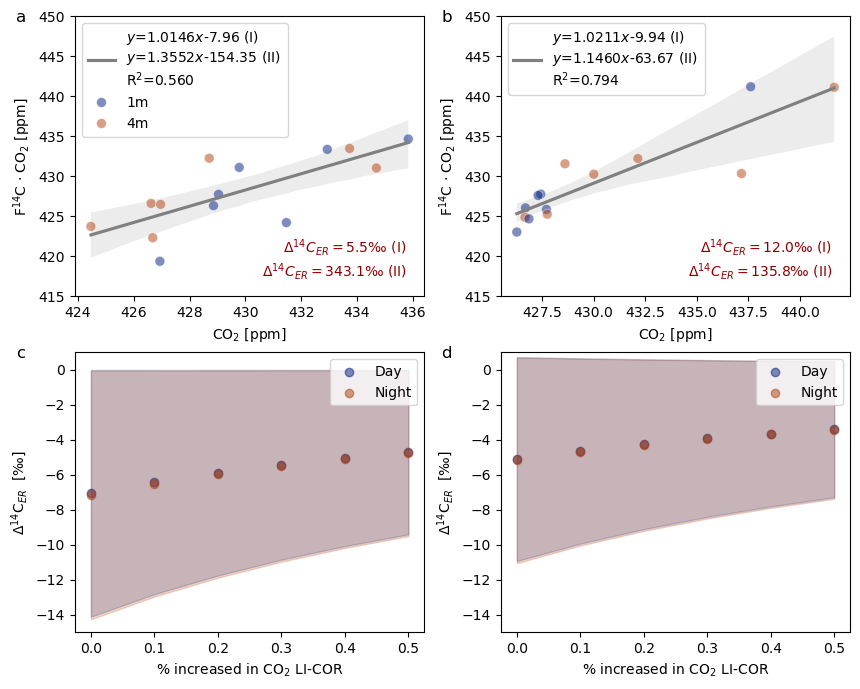

In [398]:
palette2=sns.color_palette("dark",2)
fig,ax=plt.subplots(2,2,figsize=(10,8))
from matplotlib.legend import Legend
xx=['a','b','c','d']
s=50

exp=['Control','Drought']
D14I=np.zeros(2);D14II=np.zeros(2)
for i in range(2): #drought and control.
    #fw2=fw[fw['Experiment']==exp[i]]
    print(exp[i])
    fw2=df[df['Experiment']==exp[i]]
    MT_x=fw2["CO2"]
    MT_y=fw2.F14C*fw2.CO2
    slope,intercept,r_value,pv,se=stats.linregress(MT_x,MT_y) # Type I.
    results=regress2(MT_x,MT_y) # Type II.
    sns.regplot(data=fw2,x=MT_x,y=MT_y,ax=ax[0,i],scatter=False,color='gray',
            label="$y$={0:.4f}$x${1:.2f}".format(slope,intercept)+" (I)\n$y$={0:.4f}$x${1:.2f}".format(results['slope'],results['intercept'])+
            " (II) \nR$^2$={0:.3f}".format(results['r']**2))
    sns.scatterplot(data=fw2,x=MT_x,y=MT_y,hue="height",palette=palette2,s=s,
                alpha=0.5,ax=ax[0,i])
    handles,labels=ax[0,i].get_legend_handles_labels()
    if i==0:ax[0,i].legend(handles=handles[0:],labels=labels[0:],loc='upper left')
    else:ax[0,i].legend(handles=handles[0:],labels=labels[0:1],loc='upper left')
    ax[0,i].set_xlabel(r'CO$_2$ [ppm]')
    ax[0,i].set_ylabel(r'F$^{14}$C $\cdot$ CO$_2$ [ppm]')
    ax[0,i].set_ylim(415,450)
    #ax[0,i].set_title(treatn[i])
    D14I[i]=slope
    D14II[i]=results['slope']

    ax[0,i].text(0.95,0.05, '$\Delta^{14}C_{ER}=$'+"{:.1f}".format(fm_D14C(D14I[i],2024))+
               '‰ (I)'+'\n$\Delta^{14}C_{ER}=$'+"{:.1f}".format(fm_D14C(D14II[i],2024))+'‰ (II)',
        verticalalignment='bottom', horizontalalignment='right',transform=ax[0,i].transAxes,
        color='darkred', fontsize=10)
    ax[0,i].text(-0.17,0.98,xx[i],transform=ax[0,i].transAxes,fontsize=12)
    
    
ll=['Day','Night']

for  j in range(2): # treatments
    for i in range(2):# approaches
        if i==0:ER=ERD14Ca2
        if i==1:ER=ERD14Ca3
        ers=pd.DataFrame(ER[j])
        er=ers.mean()
        ax[1,j].scatter(pp,er,alpha=0.5,label=ll[i],color=palette2[i])
        ax[1,j].set_ylim(-15,1)
        ax[1,j].fill_between(pp,er-ers.std(),er+ers.std(),alpha=0.2,color=palette2[i])

   # ax[1,j].set_title(treatn[j])
    ax[1,j].legend()
    ax[1,j].set_ylabel(ytit[1])
    ax[1,j].set_xlabel('% increased in CO$_{2}$ LI-COR')
    ax[1,j].text(-0.17,0.98,xx[j+2],transform=ax[1,j].transAxes,fontsize=12)

plt.subplots_adjust(wspace=0.22,hspace=0.2)
fig.savefig('Figures/Data_field/14C_ER_all.pdf')

### Ecosystem CO2 proportions from other sites 

In [80]:
fm_D14C(0.992676738233217,2023)

-16.050296522770346

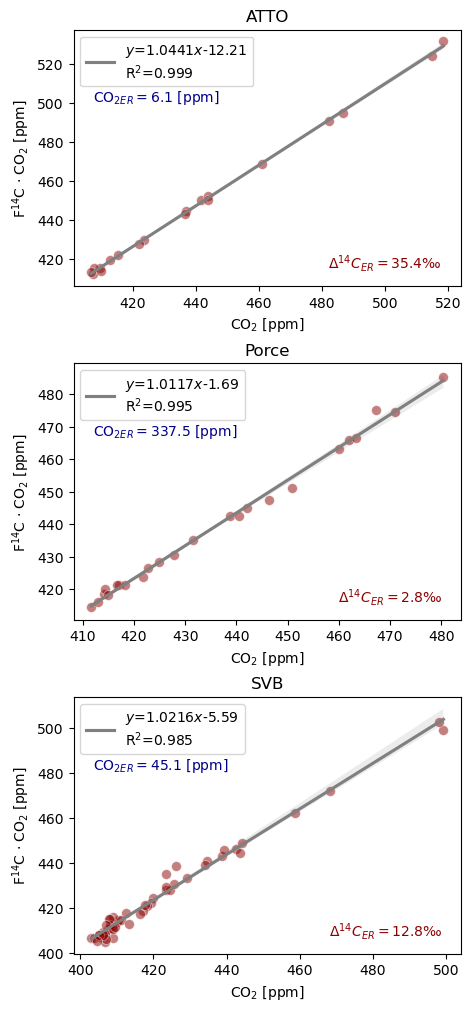

In [118]:
# Read data 
fw=pd.read_excel('~/Radiocarbon/ATTO2019.xlsx')
ATTO=pd.DataFrame({'D14C':fw[fw.columns[3]],'CO2':fw[fw.columns[6]]})
fw=pd.read_excel('~/Radiocarbon/Porce2023.xlsx')
Porce=pd.DataFrame({'D14C':fw[fw.columns[12]],'CO2':fw[fw.columns[4]]})
fw=pd.read_excel('~/Radiocarbon/SVB2022.xlsx')
SVB=pd.DataFrame({'D14C':fw[fw.columns[5]],'CO2':fw[fw.columns[9]]})
bkg=pd.DataFrame({'D14C':[8.0,-16.05,-2.03],'CO2':[408.2,425,410.95]})
tit=['ATTO','Porce','SVB']
palette2=sns.color_palette("dark",2)
s=50
fig,ax=plt.subplots(3,figsize=(5,12))

for i in range(3):
    if i==0:data=ATTO; yy=2019
    if i==1:data=Porce; yy=2023
    if i==2:data=SVB; yy=2022
    MT_x=data.CO2
    MT_y=D14C_fm(data.D14C,yy,lft=8267)*data.CO2
    results=regress2(MT_x,MT_y)
    sns.regplot(data=data,x=MT_x,y=MT_y,ax=ax[i],scatter=False,color='gray',
            label="$y$={0:.4f}$x${1:.2f}".format(results['slope'],results['intercept'])+
            " \nR$^2$={0:.3f}".format(results['r']**2))
    sns.scatterplot(data=data,x=MT_x,y=MT_y,color='darkred',s=s,
                alpha=0.5,ax=ax[i])
    ax[i].text(0.95,0.05, '$\Delta^{14}C_{ER}=$'+"{:.1f}".format(fm_D14C(results['slope'],yy))+
               '‰',verticalalignment='bottom', horizontalalignment='right',transform=ax[i].transAxes,
        color='darkred',fontsize=10)
    ax[i].set_title(tit[i])
    ax[i].set_xlabel(r'CO$_2$ [ppm]')
    ax[i].set_ylabel(r'F$^{14}$C $\cdot$ CO$_2$ [ppm]')
    
    CO2ER=(np.mean(data.CO2)*np.mean(data.D14C)-bkg.CO2[i]*bkg.D14C[i])/(fm_D14C(results['slope'],yy)-bkg.D14C[i])
    ax[i].text(0.05,0.7, 'CO$_{2ER}=$'+"{:.1f}".format(CO2ER)+
               ' [ppm]',verticalalignment='bottom', horizontalalignment='left',transform=ax[i].transAxes,
        color='darkblue',fontsize=10)
    
    
    
plt.subplots_adjust(hspace=0.3)


In [115]:
np.mean(data.D14C)

7.783447706568976

In [101]:
fm_D14C(results['slope'],yy)

12.783139191880677